In [1]:
from ma_predictor.src.predictor import Predictor
from ma_predictor.src.predictor_config import DEFAULT_CONF, PredictionConfig,SEQ_ENCODING_EXTERNAL
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from Bio import SeqIO
import tensorflow as tf
from external.SequenceEncoding.SequenceEncoding import SequenceEncoding, get_dict
from ma_predictor.src.input_prep.encode import OneHotEncoderSeq, RadianEncoder, MixedEncoder
from ma_predictor.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from ma_predictor.src.models.common.models import BaseConvolutionalWrapper, BaseLinearWrapper
from ma_predictor.src.input_prep.encode import RadiousPhobosEncoder
from keras.utils.vis_utils import plot_model
from Bio.PDB.PDBParser import PDBParser
import os
import matplotlib.pyplot as plt

## Prepare data

In [2]:
DATA_DIR = '/home/users/sdunin/calc/TCST'
data = f'{DATA_DIR}/offline_data/cache/af2_true_full.features.p'
data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
val_ids = set(data[data['class'] == 'val'].index)
idx = list(data.index)

## Train and validate

In [3]:
conf = SEQ_ENCODING_EXTERNAL
conf.model_config = {
    'activation': 'tanh',
    'norm': True,
    'n_layers': 1,
    'kernel_sizes': (3, 5),
    'lstm': 2,
    'dense': 2
}
conf.model_config['epochs'] = 100
conf.operator.parallel = True
conf.operator.encoder = RadiousPhobosEncoder()
mod = Predictor('hamp_rot', config=conf)
# trained = mod.train(data, ids=idx, val_ids=val_ids)

In [4]:
plt.plot(trained.history.history['mae'])
plt.plot(trained.history.history['val_mae'])
plt.title('model absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

NameError: name 'trained' is not defined

In [ ]:
plt.plot(trained.history.history['loss'])
plt.plot(trained.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Validation set results 

In [27]:
val = data.loc[val_ids]
seqs = list(val.train_seq)
tr=[]
for n,r in val.iterrows():
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seqs)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

Text(0.5, 1.0, 'Predictions for validation set')

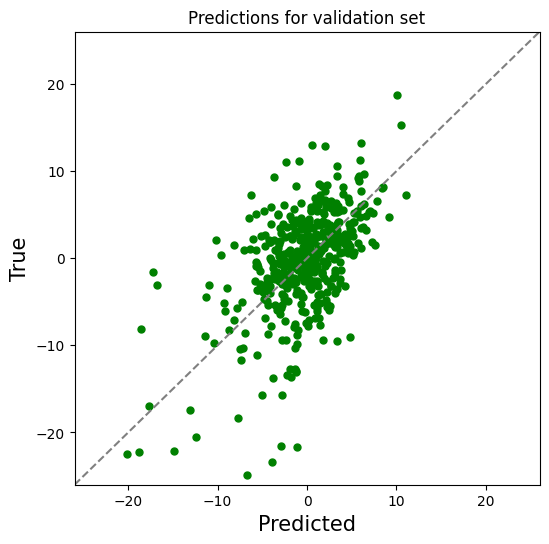

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)
ax.scatter(pr, tr, color='green', s=25)
ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')
ax.set_xlabel('Predicted', size=15)
ax.set_ylabel('True', size=15)
ax.set_title('Predictions for validation set')

## Test on PDB

In [7]:
test_data = pd.read_pickle('../../TCST/hamp_svm/pdb_measure.p')
# usuwanie mutantow
# 3lnr nie jest mutantem, ale bywa problematyczny
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq'}, inplace=True)
test_data=test_data.drop(['5jeq.pdb',
            '5jef.pdb',
            '3zrv.pdb',
            '2lfs.pdb',
            '3zrw.pdb',
            '3zcc.pdb',
            '2l7i.pdb', '2y20.pdb', '2y21.pdb', '2y0q.pdb',
                    
            '3lnr.pdb', 
                    '4i44.pdb', '4i3m.pdb'

           
           ])
test_data['n_seq'] = test_data['n_seq'].apply(lambda x:x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x:x[1:-1])
seq = []
tr = []
for n,r in test_data.iterrows():
    seq.append(r['n_seq'] + r['c_seq'])
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seq)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

Encoded 1/16 sequences
Encoded 2/16 sequences
Encoded 3/16 sequences
Encoded 4/16 sequences
Encoded 5/16 sequences
Encoded 6/16 sequences
Encoded 7/16 sequences
Encoded 8/16 sequences
Encoded 9/16 sequences
Encoded 10/16 sequences
Encoded 11/16 sequences
Encoded 12/16 sequences
Encoded 13/16 sequences
Encoded 14/16 sequences
Encoded 15/16 sequences
Encoded 16/16 sequences
Encoded 1/16 sequences
Encoded 2/16 sequences
Encoded 3/16 sequences
Encoded 4/16 sequences
Encoded 5/16 sequences
Encoded 6/16 sequences
Encoded 7/16 sequences
Encoded 8/16 sequences
Encoded 9/16 sequences
Encoded 10/16 sequences
Encoded 11/16 sequences
Encoded 12/16 sequences
Encoded 13/16 sequences
Encoded 14/16 sequences
Encoded 15/16 sequences
Encoded 16/16 sequences
1/1 [==============================] - 1s 1s/step


Text(0.5, 1.0, 'Predictions for WT HAMPs (with mutants)')

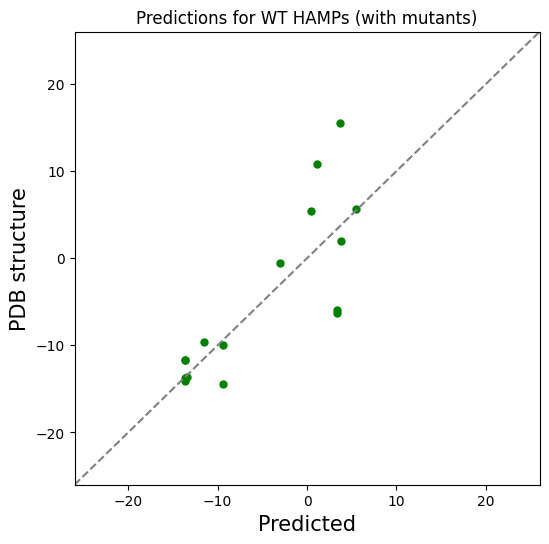

In [8]:
fig, ax = plt.subplots(1,1, figsize=(6, 6), dpi=100)
ax.scatter(pr, tr, color='green', s=25)
ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')
ax.set_xlabel('Predicted', size=15)
ax.set_ylabel('PDB structure', size=15)
ax.set_title('Predictions for WT HAMPs (with mutants)')

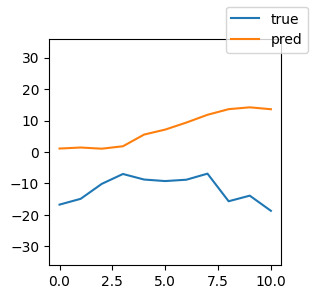

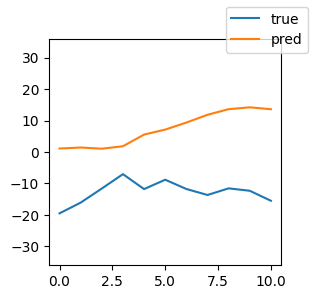

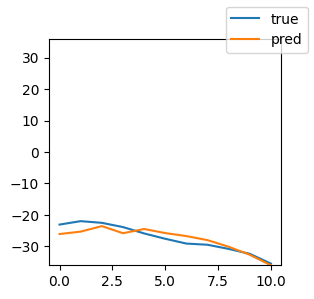

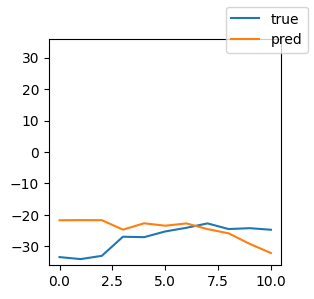

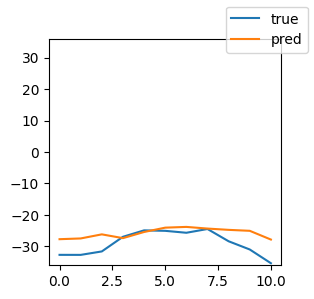

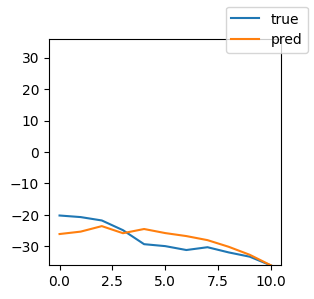

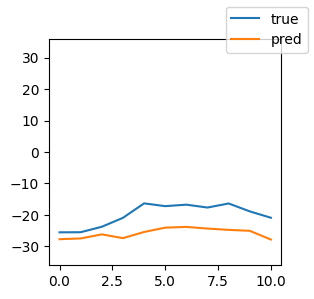

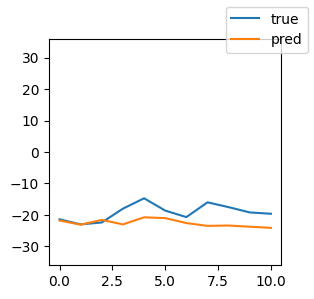

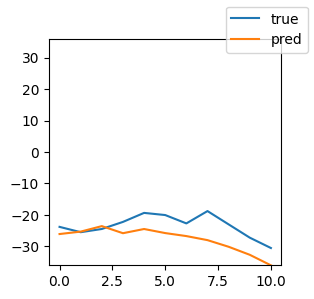

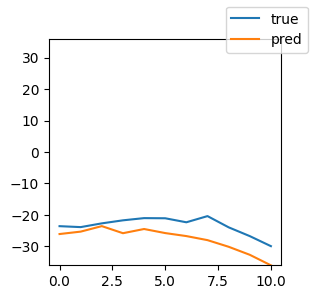

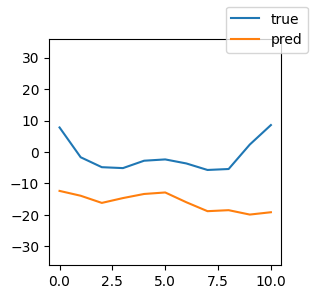

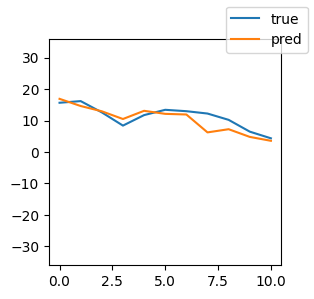

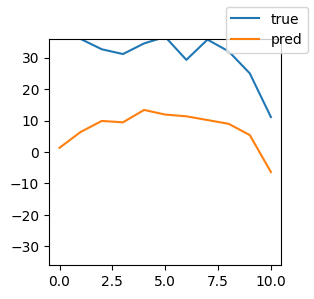

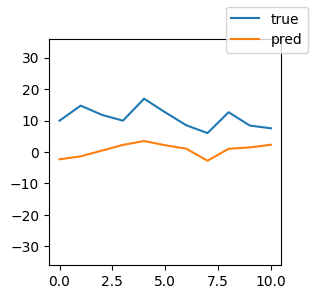

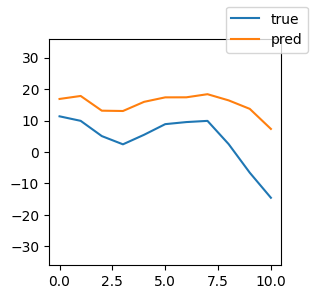

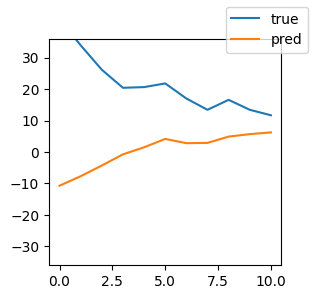

In [10]:
for i in range(len(test_data)):
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)
    r = test_data.iloc[i]
    tr = (r['rot'][0::2] + r['rot'][1::2]) / 2
    pred = res.iloc[i]['N_pred']
    ax.plot(tr, label='true')
    ax.plot(pred, label='pred')
    ax.set_ylim(-36, 36)
    fig.legend(); pass

## Model analysis

In [26]:
mod = Predictor('hamp_rot', config=conf)
pred, md, x = mod.predict(seqs, with_model=True)
from keras.utils.vis_utils import plot_model
plot_model(md._model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

''

In [13]:
from keract import get_activations
import keract

''

In [14]:
activations = get_activations(md._model, x, auto_compile=True)

In [30]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x[np.random.choice(x.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer((md._model.layers[0].input, md._model.layers[0].output), background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
# shap_values = e.shap_values(x[1:5])

# plot the feature attributions
# shap.image_plot(shap_values, -x[1:5])


Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


AssertionError: The model output must be a vector or a single value!

## Feature analysis (permutation method)

In [15]:
def mse(tr, exp):
    sm = 0
    for t, e in zip(tr, exp):
        sm += (t - e) ** 2
    return sm / len(exp)


def feature_importance(seqs, model):
    result = model.predict(seqs)
    pos_res = []
    h_size=11
    for pos in range(len(seqs[0])):
        pos_seqs = []
        lll = []
        for seq in seqs:
            new_seqs = []
            for i in range(len(seq)):
                if (pos >= h_size and i >= h_size) or (pos < h_size and i < h_size):
                    if i != pos and seq[pos] != seq[i]:
                        ll = list(seq)
                        cw = ll[pos]
                        ll[pos] = ll[i]
                        ll[i] = cw
                        new_seqs.append(''.join(ll))
            lll.append(len(new_seqs))
            pos_seqs.extend(new_seqs)
        new_result = model.predict(pos_seqs)
        acc = 0
        aa_imp = []
        for n, size in enumerate(lll):
            data = new_result.iloc[acc:acc + size]
            acc += size
            total = 0
            for res in data['N_pred']:
                prev = result.iloc[n]['N_pred']
                total += mse(res, prev)
            aa = seqs[n][pos]
            if total:
                aa_imp.append({'aa': aa, 'impact': total[0] / size})
        aa_imp = pd.DataFrame(aa_imp).groupby('aa', as_index=False).agg({'impact': 'mean'}).assign(pos=pos)
        pos_res.append(aa_imp)
    rr = pd.concat(pos_res)
    rr.sort_values(by=['pos', 'impact'], ascending=[True, False], inplace=True)
    return rr

In [24]:
importance = feature_importance(seqs, mod)

''

<AxesSubplot:xlabel='pos', ylabel='impact'>

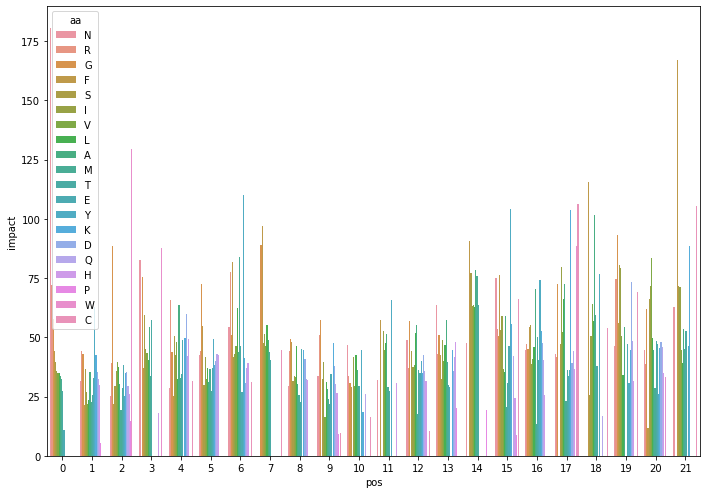

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.barplot(x='pos', y='impact', hue='aa', data=importance, ax=ax)

In [20]:
importance

,aa,impact,pos
7,N,180.623474,0
8,R,72.076874,0
3,G,57.894274,0
2,F,44.093144,0
9,S,39.600104,0
...,...,...,...
9,T,52.686700,21
11,Y,46.388861,21
6,M,45.022024,21
10,V,44.838907,21


In [29]:
feature_importance(['AAAAACAAAAAAAAAFAAAA'], mod)

Encoded 1/1 sequences
Encoded 1/1 sequences
1/1 [==============================] - 1s 1s/step
Encoded 1/1 sequences
Encoded 1/1 sequences
1/1 [==============================] - 1s 1s/step
Encoded 1/1 sequences
Encoded 1/1 sequences
1/1 [==============================] - 1s 1s/step
Encoded 1/1 sequences
Encoded 1/1 sequences
1/1 [==============================] - 1s 1s/step
Encoded 1/1 sequences
Encoded 1/1 sequences
1/1 [==============================] - 1s 1s/step
Encoded 1/1 sequences
Encoded 1/1 sequences
1/1 [==============================] - 2s 2s/step
Encoded 1/10 sequences
Encoded 2/10 sequences
Encoded 3/10 sequences
Encoded 4/10 sequences
Encoded 5/10 sequences
Encoded 6/10 sequences
Encoded 7/10 sequences
Encoded 8/10 sequences
Encoded 9/10 sequences
Encoded 10/10 sequences
Encoded 1/10 sequences
Encoded 2/10 sequences
Encoded 3/10 sequences
Encoded 4/10 sequences
Encoded 5/10 sequences
Encoded 6/10 sequences
Encoded 7/10 sequences
Encoded 8/10 sequences
Encoded 9/10 sequence

,aa,impact,pos
0,A,2.423900,0
0,A,1.997372,1
0,A,4.180680,2
0,A,0.876958,3
0,A,1.232048,4
0,C,1.690145,5
0,A,0.974999,6
0,A,2.652939,7
0,A,1.554970,8
0,A,0.605822,9
